In [1]:
from keras.utils import normalize
import numpy as np
from matplotlib import pyplot as plt
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import sys
import time

from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

Segmentation Models: using `tf.keras` framework.


In [2]:
"""Load data"""
sys.path.extend(['..'])
from data.adv_data_generator import ImageLoader

file = ["train"]
type_mod = ["img","mask","aug"]
dataset_aug = [[],[],[]]
num = 0
for i in file:
    for j in type_mod:
        loader = ImageLoader(i, j)
        dataset_aug[num] = loader.loadAug()
        num += 1

train_img= dataset_aug[0]
train_mask = dataset_aug[1]
train_aug = dataset_aug[2]

In [3]:
sys.path.extend(['..'])
from data.adv_data_generator import ImageLoader

file = ["val","test"]
type_mod = ["images","masks"]
dataset = [[],[],[],[]]
num = 0
for i in file:
    for j in type_mod:
        loader = ImageLoader(i, j)
        dataset[num] = loader.loadData()
        num += 1

val_img= dataset[0]
val_mask = dataset[1]
test_img = dataset[2]
test_mask = dataset[3]

In [4]:
"""Check the shape"""
print(train_img.shape)
print(val_img.shape)
print(test_img.shape)

(29920, 64, 64, 3)
(32079, 64, 64, 3)
(32079, 64, 64, 3)


In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(131)
plt.imshow(train_img[1])
plt.title('Image')
plt.subplot(132)
plt.imshow(train_aug[1])
plt.title('Augmented')
plt.subplot(133)
plt.imshow(train_mask[1])
plt.title('Mask')
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(test_img[12])
plt.title('Image')
plt.subplot(122)
plt.imshow(test_mask[12])
plt.title('Mask')
plt.show()

In [5]:
import random

'''
(1) Set the seed
(2) Generate a random permutation of indices
(3) Use the same random indices for sampling both arrays
'''

def sampling(img, mask, seed, percentage=0.2):
    sample_size = int(len(img) * percentage)
    random.seed(seed)
    random_indices = random.sample(range(len(img)), sample_size)
    sample_img = img[random_indices]
    sample_mask = mask[random_indices]

    return sample_img, sample_mask

sam_val_img, sam_val_mask = sampling(val_img, val_mask, 4)
sam_test_img, sam_test_mask = sampling(test_img, test_mask, 7)

print(sam_val_mask.shape[0])
print(sam_test_mask.shape[0])
print(np.unique(sam_val_mask))

6415
6415
[0 1 2 3 4 5 6 7]


In [6]:
'''Define variable to run the model'''
# X = np.concatenate((mod_train_img, mod_train_aug), axis=0)
# y = np.concatenate((mod_train_mask, mod_train_mask), axis=0)
X, y = train_img, train_mask
X_val = sam_val_img
y_val = sam_val_mask

In [7]:
n_classes = 8
from keras.utils import to_categorical
y_cat = to_categorical(y, num_classes=n_classes)
y_val_cat = to_categorical(y_val, num_classes=n_classes)

In [8]:
from keras.models import Model
from keras.layers import *

In [18]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Layer

def se_block(input_feature, ratio=2):

    channel = input_feature.shape[3]

    se_feature = GlobalAveragePooling2D()(input_feature)
    se_feature = Reshape((1, 1, channel))(se_feature)
    assert se_feature.shape[1:] == (1,1,channel)
    se_feature = Dense(channel // ratio,
                    activation='relu',
                    kernel_initializer='he_normal',
                    use_bias=True,
                    bias_initializer='zeros')(se_feature)
    assert se_feature.shape[1:] == (1,1,channel//ratio)
    se_feature = Dense(channel,
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=True,
                    bias_initializer='zeros')(se_feature)
    assert se_feature.shape[1:] == (1,1,channel)

    se_feature = multiply([input_feature, se_feature])
    return se_feature

def spatial_attention(input_feature):
    kernel_size = 7

    channel = input_feature.shape[3]
    cbam_feature = input_feature

    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True),
                      output_shape=lambda input_shape: (input_shape[0], input_shape[1], input_shape[2], 1))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True),
                     output_shape=lambda input_shape: (input_shape[0], input_shape[1], input_shape[2], 1))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                kernel_size=kernel_size,
                strides=1,
                padding='same',
                activation='sigmoid',
                kernel_initializer='he_normal',
                use_bias=False)(concat)	
    assert cbam_feature.shape[-1] == 1

    return multiply([input_feature, cbam_feature])

In [19]:
def usegnet_model_base(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, pool_size=(2, 2)):

    # encoder 
    
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)) 
    
    conv_1 = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name="block1_conv1")(inputs) 
    conv_1 = BatchNormalization()(conv_1) 
    conv_1 = Activation("relu")(conv_1) 
    conv_2 = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name="block1_conv2")(conv_1) 
    conv_2 = BatchNormalization()(conv_2) 
    conv_2 = Activation("relu")(conv_2)
    se_1 = se_block(conv_2, 2)
    
    pool_1 = MaxPooling2D(pool_size, name="block1_pool")(se_1)
    
    conv_3 = Conv2D(128, (3, 3), padding="same" , kernel_initializer='he_normal', name="block2_conv1")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal',  name="block2_conv2")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)
    se_2 = se_block(conv_4, 2)
    
    pool_2 = MaxPooling2D(pool_size, name="block2_pool")(se_2)
    
    conv_5 = Conv2D(256, (3, 3), padding="same" , kernel_initializer='he_normal', name="block3_conv1")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Conv2D(256, (3, 3), padding="same" , kernel_initializer='he_normal', name="block3_conv2")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Conv2D(256, (3, 3), padding="same" , kernel_initializer='he_normal', name="block3_conv3")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)
    se_3 = se_block(conv_7, 2)
    
    pool_3 = MaxPooling2D(pool_size, name="block3_pool")(se_3)
    
    #bottleneck
    conv_11 = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal', name="block5_conv1")(pool_3)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Conv2D(256, (3, 3), padding="same" , kernel_initializer='he_normal',  name="block5_conv2")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Conv2D(256, (3, 3), padding="same" , kernel_initializer='he_normal',  name="block5_conv3")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)
    se_4 = se_block(conv_13, 2)
    sam = spatial_attention(se_4)
       
    #decoder
    unpool_1 = UpSampling2D((pool_size))(sam)
    
    conv_14 = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal')(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal')(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal')(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)
    
    unpool_2 = UpSampling2D((pool_size))(conv_16)
    
    conv_17 = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal')(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal')(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    
    unpool_3 = UpSampling2D((pool_size))(conv_18)
    
    #concatenation (unpool_4, conv_2)
    merge = concatenate([unpool_3,se_1], axis = -1)
    
    conv_19 = Conv2D(64, (1, 1), padding="same", kernel_initializer='he_normal')(merge)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)
    
    conv_20 = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal')(conv_19)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    
    conv_21 = Conv2D(n_classes, (1, 1), padding="same", kernel_initializer='he_normal')(conv_20)
    conv_21 = BatchNormalization()(conv_21)

    outputs = Activation("softmax")(conv_21)
         
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [11]:
IMG_HEIGHT = X.shape[1]
IMG_WIDTH  = X.shape[2]
IMG_CHANNELS = X.shape[3]

In [20]:
from keras.optimizers import Adam

def get_model(learning_rate=0.001):
    # Create the model
    model = usegnet_model_base(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
    
    # Compile the model with custom optimizer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', sm.metrics.iou_score])
    
    return model

In [21]:
model = get_model(learning_rate=0.0001)
# model.summary()

In [22]:
start_time = time.time()
history = model.fit(X, y_cat, 
                    batch_size = 64, 
                    verbose=1, 
                    epochs=10, 
                    validation_data=(X_val, y_val_cat), 
                    shuffle=False)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.4f} seconds")

Epoch 1/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 1303s 3s/step - accuracy: 0.5174 - iou_score: 0.0838 - loss: 1.6549 - val_accuracy: 0.6642 - val_iou_score: 0.1054 - val_loss: 1.3165
Epoch 2/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 1289s 3s/step - accuracy: 0.6663 - iou_score: 0.1150 - loss: 1.2953 - val_accuracy: 0.6791 - val_iou_score: 0.1181 - val_loss: 1.2312
Epoch 3/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 1289s 3s/step - accuracy: 0.6978 - iou_score: 0.1292 - loss: 1.1884 - val_accuracy: 0.6779 - val_iou_score: 0.1239 - val_loss: 1.1770
Epoch 4/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 1289s 3s/step - accuracy: 0.7176 - iou_score: 0.1417 - loss: 1.1060 - val_accuracy: 0.7006 - val_iou_score: 0.1360 - val_loss: 1.0913
Epoch 5/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 1289s 3s/step - accuracy: 0.7336 - iou_score: 0.1536 - loss: 1.0338 - val_accuracy: 0.7069 - val_iou_score: 0.1480 - val_loss: 1.0658
Epoch 6/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 1290s 3s/step - accuracy: 0.7471 - iou_score: 0.1651 - loss: 0.9697 - val_accuracy: 0.6776

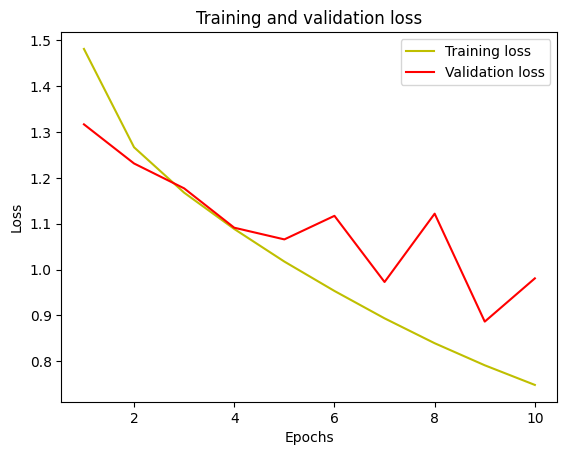

In [23]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

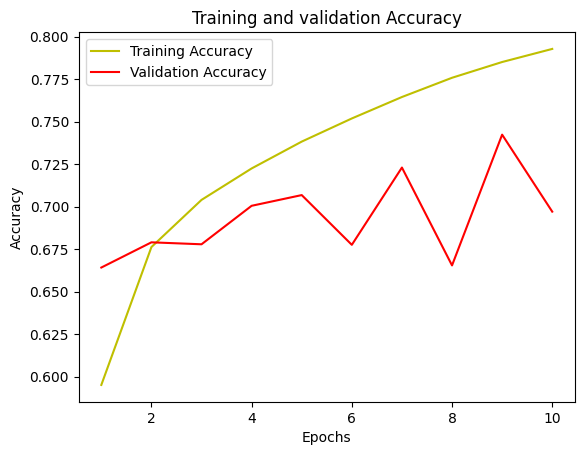

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
Xtest, ytest = sam_test_img, sam_test_mask

In [26]:
Ytest_cat = to_categorical(ytest, num_classes=n_classes)

In [ ]:
# Evaluasi model
loss, accuracy, iou_score = model.evaluate(Xtest, Ytest_cat)
print(accuracy)
print(iou_score)

In [27]:
# Predict and evaluate
y_pred = model.predict(Xtest)
y_pred_classes = np.argmax(y_pred, axis=-1)
y_true_classes = ytest

201/201 ━━━━━━━━━━━━━━━━━━━━ 62s 305ms/step


In [28]:
# Flatten the arrays
y_pred_flat = y_pred_classes.flatten()
y_true_flat = y_true_classes.flatten()

In [29]:
# Generate the classification report
from sklearn.metrics import classification_report
report = classification_report(y_true_flat, y_pred_flat, target_names=['Class 0', 
                                                                       'Class 1', 
                                                                       'Class 2', 
                                                                       'Class 3', 
                                                                       'Class 4', 
                                                                       'Class 5', 
                                                                       'Class 6', 
                                                                       'Class 8'])
print(report)

C:\Users\kholid\anaconda3\envs\tir\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kholid\anaconda3\envs\tir\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         8
     Class 1       0.40      0.13      0.19    293759
     Class 2       0.40      0.19      0.26    324962
     Class 3       0.35      0.50      0.41   1487533
     Class 4       0.57      0.57      0.57   2862958
     Class 5       0.59      0.77      0.67   7413470
     Class 6       0.96      0.76      0.85  12772966
     Class 8       0.41      0.46      0.43   1120184

    accuracy                           0.70  26275840
   macro avg       0.46      0.42      0.42  26275840
weighted avg       0.74      0.70      0.71  26275840



C:\Users\kholid\anaconda3\envs\tir\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
#IOU

n_classes = 8
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ytest, y_pred_classes)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.30230686
